###Baseline 2 - тональность отдельных аспектов

Обучим свою модель на основе модели [cointegrated/rubert-tiny-sentiment-balanced](https://huggingface.co/cointegrated/rubert-tiny-sentiment-balanced).

Чтобы модель научилась приписывать тональность отдельным аспектам, выделим аспекты attention_mask.

In [1]:
import pandas as pd
from nltk.tokenize import sent_tokenize
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import nltk
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import warnings
from copy import deepcopy
from collections import defaultdict
from transformers import BertModel, BertTokenizer, AdamW
import matplotlib.pyplot as plt

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

####**Training data**

In [2]:
ans = pd.read_csv('https://raw.githubusercontent.com/PhilBurub/NLPcourse_HSE/main/train_aspects.txt', header=None, delimiter='\t', index_col=0,
                  names=['aspect', 'entity', 'start', 'end', 'sentiment'])
texts = pd.read_csv('https://raw.githubusercontent.com/PhilBurub/NLPcourse_HSE/main/train_reviews.txt', header=None, delimiter='\t', index_col=0,
                    names=['text'])

####**Dataset creation**

In [3]:
def boudaries(id_, text):
  out = []
  new_text = text
  cur = 0
  for sent in sent_tokenize(text):
    start = new_text.find(sent)
    end = start + len(sent)
    out.append((id_, sent, cur + start, cur + end))
    cur += end
    new_text = new_text[end:]
  return pd.DataFrame(out, columns=['id', 'text', 'start', 'end'])

In [4]:
def create_mask(tokens, asp_tokens):
  mask_li = []
  for token in tokens:
    if token in asp_tokens:
      mask_li.append(1)
    else:
      mask_li.append(0)

  return mask_li

In [5]:
device='cuda'

rubert_model = AutoModel.from_pretrained("cointegrated/rubert-tiny-sentiment-balanced").to(device)
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny-sentiment-balanced", device=device)

config.json:   0%|          | 0.00/884 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.2M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/377 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [115]:
class ContextDataset(Dataset):
  def __init__(self, texts, outputs):

    new = pd.DataFrame()
    for id_, text in texts.iterrows():
      new = pd.concat((new, boudaries(id_, text['text'])))

    out = []
    for text_id, row in outputs.iterrows():
      slice_ = new[(new['id'] == text_id) & (new['start'] <= row['start']) & (new['end'] >= row['end'])]
      if len(slice_) == 0:
        print(row, '0')
        continue
      if len(slice_) > 1:
        print(row, '>1')
        continue
      out.append((text_id, row['entity'], row['aspect'], row['start'], row['end'], slice_['text'].item(), row['sentiment']))
    self.contexts = pd.DataFrame(out, columns=['id', 'input', 'aspect', 'start', 'end', 'context', 'sentiment'])

    self.map_sent = {0: -1, 'negative': 0, 'neutral': 1, 'positive': 2,
                     'both': 3}
    self.map_asp = {0: -1, 'Food': 0, 'Interior': 1, 'Price': 2,
                    'Service': 3, 'Whole': 4}

  def __len__(self):
    return len(self.contexts)

  def __getitem__(self, idx):

    row = self.contexts.loc[idx]
    text = row['context']
    tokens = tokenizer.encode_plus(text, max_length=150, add_special_tokens=True, padding='max_length', truncation=True, return_tensors='pt', return_token_type_ids=False)

    aspect_word = row['input']
    aspect_token_ids = tokenizer.encode(aspect_word, add_special_tokens=False, return_tensors='pt')
    asp_tokens = aspect_token_ids[0]
    tokens_list = tokens['input_ids'].tolist()[0]

    attention_mask = create_mask(tokens_list, asp_tokens)

    sentiment = [self.map_sent.get(row['sentiment'])]

    return {'review_text': text, 'input_ids': tokens['input_ids'], 'attention_mask': attention_mask, 'targets': torch.tensor(sentiment, dtype = torch.long).squeeze()}

####**Train set creation**

In [116]:
train_set = ContextDataset(texts, ans.iloc[:4000])
test_set = ContextDataset(texts, ans.iloc[4000:])

In [117]:
train_set.contexts

,id,input,aspect,start,end,context,sentiment
0,3976,ресторане,Whole,71,80,Решил написать отзыв о ресторане в котором отм...,neutral
1,3976,ресторанах,Whole,198,208,Решил написать отзыв о ресторане в котором отм...,neutral
2,3976,ресторане,Whole,256,265,Но теперь о ресторане.,neutral
3,3976,Столик бронировали,Service,267,285,Столик бронировали заранее и сделали так как п...,neutral
4,3976,администратор,Service,322,335,Столик бронировали заранее и сделали так как п...,positive
...,...,...,...,...,...,...,...
3995,15567,Официантка,Service,609,619,Официантка объяснила задержку именно большим о...,negative
3996,15567,горячие полотенца,Interior,748,765,"Несколько раз спрошенные горячие полотенца, та...",negative
3997,15567,интерьер,Interior,907,915,"Все могло бы быть неплохо: месторасположение, ...",positive
3998,15567,кухня,Food,917,922,"Все могло бы быть неплохо: месторасположение, ...",positive


####**Dataloaders**

In [9]:
train_data_loader = DataLoader(train_set, batch_size=16, num_workers=4)
test_data_loader = DataLoader(test_set, batch_size=16, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


####**Model loading**

In [118]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained("cointegrated/rubert-tiny-sentiment-balanced")
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    ).pooler_output

    output = self.drop(pooled_output)

    return self.out(output)

In [11]:
model = SentimentClassifier(4)
model = model.to(device)

####**Training functions**

In [12]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [119]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = torch.squeeze(d['input_ids']).to(device)
    attention_mask = torch.stack(d['attention_mask']).transpose(0, 1).to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    preds = torch.argmax(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [120]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = torch.squeeze(d['input_ids']).to(device)
      attention_mask = torch.stack(d['attention_mask']).transpose(0, 1).to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      preds = torch.argmax(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

####**Model training**

In [15]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    len(train_set)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(test_set)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss 0.9403976718187332 accuracy 0.629
Val loss 0.9403438471878568 accuracy 0.672346002621232

Epoch 2/10
----------
Train loss 0.8442724703550338 accuracy 0.674
Val loss 0.914426462414364 accuracy 0.6788990825688074

Epoch 3/10
----------
Train loss 0.7999422377943992 accuracy 0.6930000000000001
Val loss 0.92040213663131 accuracy 0.6788990825688074

Epoch 4/10
----------
Train loss 0.7538492946624756 accuracy 0.717
Val loss 0.9465986105302969 accuracy 0.6736566186107471

Epoch 5/10
----------
Train loss 0.7319864033758641 accuracy 0.72275
Val loss 0.9745715834821264 accuracy 0.6631716906946264

Epoch 6/10
----------
Train loss 0.7004087335169316 accuracy 0.731
Val loss 1.0032617691904306 accuracy 0.6592398427260813

Epoch 7/10
----------
Train loss 0.6715118515193462 accuracy 0.74775
Val loss 1.025561445703109 accuracy 0.6487549148099607

Epoch 8/10
----------
Train loss 0.6446697478890419 accuracy 0.76025
Val loss 1.065973421248297 accuracy 0.6461336828309305

Epoch 9/10
------

####**Model evaluation**

(0.0, 1.0)

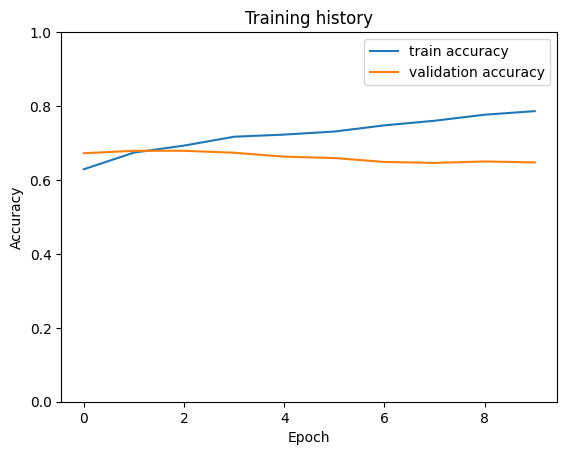

In [16]:
plt.plot(torch.stack(history['train_acc']).cpu(), label='train accuracy')
plt.plot(torch.stack(history['val_acc']).cpu(), label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

####**Getting model's predictions on dev data**

In [121]:
device='cuda'

model = SentimentClassifier(4)
model.load_state_dict(torch.load('best_model_state.bin'))
model.eval()

model.to(device)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise

Загрузка данных

In [122]:
ans_dev = pd.read_csv('https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_aspects.txt', header=None, delimiter='\t', index_col=0,
                  names=['aspect', 'entity', 'start', 'end', 'sentiment'])
texts_dev = pd.read_csv('https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_reviews.txt', header=None, delimiter='\t', index_col=0,
                    names=['text'])

In [123]:
dev_set = ContextDataset(texts_dev, ans_dev)

In [124]:
dev_data_loader = DataLoader(dev_set, batch_size=16, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [125]:
test_acc, _ = eval_model(
    model,
    dev_data_loader,
    loss_fn,
    device,
    len(dev_set)
  )

test_acc.item()

0.7008403361344538

In [126]:
df_pred = dev_set.contexts.copy()

Функция получения предсказаний

In [127]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = torch.squeeze(d['input_ids']).to(device)
      attention_mask = torch.stack(d['attention_mask']).transpose(0, 1).to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      preds = torch.argmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [128]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, dev_data_loader)

In [129]:
df_pred['sent_pred'] = list(y_pred.tolist())
df_pred['sent_pred'] = df_pred['sent_pred'].map({0:'negative', 1:'neutral', 2: 'positive', 3:'both'})

In [130]:
df_pred

,id,input,aspect,start,end,context,sentiment,sent_pred
0,3976,ресторане,Whole,71,80,Решил написать отзыв о ресторане в котором отм...,neutral,neutral
1,3976,ресторанах,Whole,198,208,Решил написать отзыв о ресторане в котором отм...,neutral,positive
2,3976,ресторане,Whole,256,265,Но теперь о ресторане.,neutral,neutral
3,3976,Столик бронировали,Service,267,285,Столик бронировали заранее и сделали так как п...,neutral,neutral
4,3976,администратор,Service,322,335,Столик бронировали заранее и сделали так как п...,positive,positive
...,...,...,...,...,...,...,...,...
1185,33043,заказ,Service,792,797,"Сели, принес официант меню, ушел, ждали минут ...",positive,positive
1186,33043,принесли,Service,798,806,"Сели, принес официант меню, ушел, ждали минут ...",positive,positive
1187,33043,приготовили,Food,880,891,"Сели, принес официант меню, ушел, ждали минут ...",positive,positive
1188,33043,оставил,Service,1017,1024,"Сели, принес официант меню, ушел, ждали минут ...",negative,neutral


In [131]:
df_pred.to_csv('dev_pred_aspects.csv', sep = '\t', header=False, columns=['id', 'aspect', 'input', 'start', 'end', 'sent_pred'])

###Baseline 3 - тональность всей категории

####**Способ 1:** собираем в один текст предложения по одной категории и определяем его тональность с помощью предобученной модели (без дообучения).

In [28]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_checkpoint = 'cointegrated/rubert-tiny-sentiment-balanced'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
if torch.cuda.is_available():
    model.cuda()

def get_sentiment(text, return_type='label'):
    """ Calculate sentiment of a text. `return_type` can be 'label', 'score' or 'proba' """
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
        proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()[0]
    if return_type == 'label':
        return model.config.id2label[proba.argmax()]
    elif return_type == 'score':
        return proba.dot([-1, 0, 1])
    return proba

In [74]:
def score(proba):
  neg, neut, pos = proba
  if abs(neg - pos) < 0.25:
    return 'both'
  elif abs(neg - neut) < 0.1 and abs(pos - neut) < 0.1:
    return 'both'
  else:
    return model.config.id2label[proba.argmax()]

In [51]:
dev_texts = pd.read_csv('https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_reviews.txt', delimiter='\t', header=None, names=['text_id', 'text'])

In [52]:
dev_set.contexts

,id,input,aspect,start,end,context,sentiment
0,3976,ресторане,Whole,71,80,Решил написать отзыв о ресторане в котором отм...,neutral
1,3976,ресторанах,Whole,198,208,Решил написать отзыв о ресторане в котором отм...,neutral
2,3976,ресторане,Whole,256,265,Но теперь о ресторане.,neutral
3,3976,Столик бронировали,Service,267,285,Столик бронировали заранее и сделали так как п...,neutral
4,3976,администратор,Service,322,335,Столик бронировали заранее и сделали так как п...,positive
...,...,...,...,...,...,...,...
1185,33043,заказ,Service,792,797,"Сели, принес официант меню, ушел, ждали минут ...",positive
1186,33043,принесли,Service,798,806,"Сели, принес официант меню, ушел, ждали минут ...",positive
1187,33043,приготовили,Food,880,891,"Сели, принес официант меню, ушел, ждали минут ...",positive
1188,33043,оставил,Service,1017,1024,"Сели, принес официант меню, ушел, ждали минут ...",negative


In [64]:
df = dev_set.contexts.copy()

In [65]:
df

,id,input,aspect,start,end,context,sentiment
0,3976,ресторане,Whole,71,80,Решил написать отзыв о ресторане в котором отм...,neutral
1,3976,ресторанах,Whole,198,208,Решил написать отзыв о ресторане в котором отм...,neutral
2,3976,ресторане,Whole,256,265,Но теперь о ресторане.,neutral
3,3976,Столик бронировали,Service,267,285,Столик бронировали заранее и сделали так как п...,neutral
4,3976,администратор,Service,322,335,Столик бронировали заранее и сделали так как п...,positive
...,...,...,...,...,...,...,...
1185,33043,заказ,Service,792,797,"Сели, принес официант меню, ушел, ждали минут ...",positive
1186,33043,принесли,Service,798,806,"Сели, принес официант меню, ушел, ждали минут ...",positive
1187,33043,приготовили,Food,880,891,"Сели, принес официант меню, ушел, ждали минут ...",positive
1188,33043,оставил,Service,1017,1024,"Сели, принес официант меню, ушел, ждали минут ...",negative


In [75]:
df = dev_set.contexts.copy()
#df_ready = df.drop_duplicates(subset=['context']).groupby(['id', 'aspect']).agg({'context': lambda x: ' '.join(x)}).reset_index()
df_ready = df.groupby(['id', 'aspect']).agg({'context': lambda x: ' '.join(x)}).reset_index()
df_ready['sent_pred'] = df_ready['context'].apply(lambda x: score(get_sentiment(x, 'proba')))

In [76]:
df_ready

,id,aspect,context,sent_pred
0,785,Food,"Что касается меню, ожидали лучшего! Меню мы за...",neutral
1,785,Interior,"Ресторан понравился, интерьер приятный, много ...",positive
2,785,Service,"Что касается торта , то он был очень вкусным ,...",positive
3,785,Whole,"Ресторан понравился, интерьер приятный, много ...",positive
4,797,Food,"Один раз днем, все понравилось,второй раз вече...",neutral
...,...,...,...,...
288,37819,Whole,Очень долго выбирали ресторан на Новогодний ка...,positive
289,38299,Food,Из еды я заказала салат с треской (посоветовал...,positive
290,38299,Interior,"Оказалось не зря... Очень уютная обстановка, н...",both
291,38299,Service,"Живем на московском и до этого не знали о том,...",positive


In [77]:
CATEGORIES = ['Whole', 'Interior', 'Service', 'Food', 'Price']

def get_full_sentiment(text, idx, df_ready):
    pred_cats = list(df_ready.loc[df_ready['id'] == idx]['aspect'])

    for c in CATEGORIES:
        if c not in pred_cats:
            s = 'absence'
        else:
            s = df_ready.loc[(df_ready['id'] == idx) & (df_ready['aspect'] == c)]['sent_pred'].item()
        yield c, s

In [78]:
with open('dev_pred_cats.txt', 'w') as f:
  for text, idx in zip(dev_texts['text'], dev_texts['text_id']):
    for c, s in get_full_sentiment(text, idx, df_ready):
      print(idx, c, s, sep="\t", file=f)

#####Evaluation

In [59]:
! wget 'https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_cats.txt'

--2023-12-28 21:58:32--  https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_cats.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7400 (7.2K) [text/plain]
Saving to: ‘dev_cats.txt’

dev_cats.txt        100%[===================>]   7.23K  --.-KB/s    in 0s      

2023-12-28 21:58:32 (111 MB/s) - ‘dev_cats.txt’ saved [7400/7400]



In [79]:
gold_test_cats_path = "dev_cats.txt"
pred_test_cats_path = "dev_pred_cats.txt"

with open(gold_test_cats_path) as gc, open(pred_test_cats_path) as pc:
    gold_labels = set(gc.readlines())
    pred_labels = set(pc.readlines())
    print(
        "Overall sentiment accuracy:",
        len(gold_labels & pred_labels) / len(gold_labels)
    )

Overall sentiment accuracy: 0.6309859154929578


####**Способ 2:** опираемся на предсказанные в безйлайне 2 тональности отдельных сущностей, агрегируем результаты по категориям с помощью правил.

Посчитаем упоминания аспектов с предсказанной тональностью, припишем

- absence - если нет упоминаний данной категории
- both - если есть упоминания с разной тональностью
- positive/neutral/negative - если все упоминания одной тональности

In [132]:
#df_pred = pd.read_csv('dev_pred_aspects.csv')
df_pred

,id,input,aspect,start,end,context,sentiment,sent_pred
0,3976,ресторане,Whole,71,80,Решил написать отзыв о ресторане в котором отм...,neutral,neutral
1,3976,ресторанах,Whole,198,208,Решил написать отзыв о ресторане в котором отм...,neutral,positive
2,3976,ресторане,Whole,256,265,Но теперь о ресторане.,neutral,neutral
3,3976,Столик бронировали,Service,267,285,Столик бронировали заранее и сделали так как п...,neutral,neutral
4,3976,администратор,Service,322,335,Столик бронировали заранее и сделали так как п...,positive,positive
...,...,...,...,...,...,...,...,...
1185,33043,заказ,Service,792,797,"Сели, принес официант меню, ушел, ждали минут ...",positive,positive
1186,33043,принесли,Service,798,806,"Сели, принес официант меню, ушел, ждали минут ...",positive,positive
1187,33043,приготовили,Food,880,891,"Сели, принес официант меню, ушел, ждали минут ...",positive,positive
1188,33043,оставил,Service,1017,1024,"Сели, принес официант меню, ушел, ждали минут ...",negative,neutral


In [ ]:
df.groupby(['id', 'aspect']).agg({'context': lambda x: ' '.join(x)}).reset_index()

.agg(lambda x:x.value_counts().index[0])

In [154]:
df_total = pd.DataFrame(df_pred.groupby(['id', 'aspect'])['sent_pred'].agg(lambda x:x.value_counts().index[0])).reset_index()

In [155]:
df_total['sent_pred'].value_counts()

positive    278
neutral      11
negative      4
Name: sent_pred, dtype: int64

In [160]:
df_total

,id,aspect,sent_pred
0,785,Food,positive
1,785,Interior,positive
2,785,Service,positive
3,785,Whole,positive
4,797,Food,positive
...,...,...,...
288,37819,Whole,positive
289,38299,Food,positive
290,38299,Interior,positive
291,38299,Service,positive


In [161]:
CATEGORIES = ['Whole', 'Interior', 'Service', 'Food', 'Price']

def get_full_sentiment(text, idx, df_ready):
    pred_cats = list(df_ready.loc[df_ready['id'] == idx]['aspect'])

    for c in CATEGORIES:
        if c not in pred_cats:
            s = 'absence'
        else:
            s = df_ready.loc[(df_ready['id'] == idx) & (df_ready['aspect'] == c)]['sent_pred'].item()
        yield c, s

In [162]:
with open('dev_pred_cats_2.txt', 'w') as f:
  for text, idx in zip(dev_texts['text'], dev_texts['text_id']):
    for c, s in get_full_sentiment(text, idx, df_total):
      print(idx, c, s, sep="\t", file=f)

In [163]:
gold_test_cats_path = "dev_cats.txt"
pred_test_cats_path = "dev_pred_cats_2.txt"

with open(gold_test_cats_path) as gc, open(pred_test_cats_path) as pc:
    gold_labels = set(gc.readlines())
    pred_labels = set(pc.readlines())
    print(
        "Overall sentiment accuracy:",
        len(gold_labels & pred_labels) / len(gold_labels)
    )

Overall sentiment accuracy: 0.7211267605633803


Ого, так качество ещё выше!

####*References*
- https://huggingface.co/cointegrated/rubert-tiny-sentiment-balanced
- https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/



---

## Baseline 2: другие эксперименты

###(1) Дообучение простой языковой модели

Дообучение простой языковой модели (не для задачи sentiment analysis/для задачи sentiment analysis) со своей простой архитектурой, без attention. Внимание к аспекту привлекается его добавлением в начало предложения перед специальным токеном классификации.

In [82]:
class ContextDataset(Dataset):
  def __init__(self, texts, outputs):

    new = pd.DataFrame()
    for id_, text in texts.iterrows():
      new = pd.concat((new, boudaries(id_, text['text'])))

    out = []
    for text_id, row in outputs.iterrows():
      slice_ = new[(new['id'] == text_id) & (new['start'] <= row['start']) & (new['end'] >= row['end'])]
      if len(slice_) == 0:
        print(row, '0')
        continue
      if len(slice_) > 1:
        print(row, '>1')
        continue
      out.append((text_id, row['entity'], row['aspect'], row['start'], row['end'], slice_['text'].item(), row['sentiment']))
    self.contexts = pd.DataFrame(out, columns=['id', 'input', 'aspect', 'start', 'end', 'context', 'sentiment'])

    self.map_sent = {0: -1, 'negative': 0, 'neutral': 1, 'positive': 2,
                     'both': 3}
    self.map_asp = {0: -1, 'Food': 0, 'Interior': 1, 'Price': 2,
                    'Service': 3, 'Whole': 4}

  def __len__(self):
    return len(self.contexts)

  def __getitem__(self, idx):
    if isinstance(idx, slice):
      one = False
    else:
      one = True

    row = self.contexts.loc[idx]
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      if one:
        row.loc['CLS'] = '[CLS]'
      else:
        row.loc[:, 'CLS'] = '[CLS]'

    sent = row[['input', 'CLS', 'context']].values
    sentence = ' '.join(sent) if one else list(map(lambda x: ' '.join(x), sent))

    aspect = [self.map_asp.get(row['aspect'])] if one else \
                              row['aspect'].apply(self.map_asp.get).tolist()
    sentiment = [self.map_sent.get(row['sentiment'])] if one else \
                              row['sentiment'].apply(self.map_sent.get).tolist()
    return sentence, torch.tensor(aspect, dtype=torch.int32), torch.tensor(sentiment, dtype=torch.int32)

In [83]:
train_set = ContextDataset(texts, ans.iloc[:4000])
test_set = ContextDataset(texts, ans.iloc[4000:])

In [84]:
train_set.__getitem__(1)

('ресторанах [CLS] Решил написать отзыв о ресторане в котором отметили прекрасный весений праздник, прочитал отзывы edik077 и Rules77777и понял что либо мы были вразных ресторанах, либо у ребят что-то незаладилось.',
 tensor([4], dtype=torch.int32),
 tensor([1], dtype=torch.int32))

In [85]:
class Classify(nn.Module):
  def __init__(self, dropout_rate=0.2, hidden_state=512, device='cuda', max_len=500):
    super().__init__()
    self.device = device
    self.max_len = max_len
    self.rubert_model = AutoModel.from_pretrained("cointegrated/rubert-tiny2").to(device)
    self.tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2", device=device)
   #  self.rubert_model = AutoModel.from_pretrained("cointegrated/rubert-tiny-sentiment-balanced").to(device)
  #   self.tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny-sentiment-balanced", device=device)

    self.emb = nn.Embedding(5, 128)

    self.main = nn.Sequential(
        nn.Linear(440, hidden_state),
        nn.ReLU(),
        nn.BatchNorm1d(hidden_state),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_state, hidden_state // 4),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_state // 4, hidden_state // 16),
        nn.ReLU(),
        nn.BatchNorm1d(hidden_state // 16),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_state // 16, hidden_state // 64),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_state // 64, 4),
        nn.Softmax(dim=-1))


    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(440, 4)

  def embed_bert_cls(self, texts):
    t = self.tokenizer(texts,
                       return_tensors='pt',
                       padding='max_length',
                       max_length=self.max_len).to(self.device)
    with torch.no_grad():
        model_output = self.rubert_model(**t)
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings

  def forward(self, sents, aspects):
    sent_embedded = self.embed_bert_cls(sents)
    asp_embed = self.emb(aspects.to(self.device)).squeeze(1)
    x = torch.concat((sent_embedded, asp_embed), dim=1)
    x = self.drop(x)
    x = self.out(x)

    return x

In [87]:
train = DataLoader(train_set, 128, shuffle=True)
test = DataLoader(test_set, 128, shuffle=False)

In [102]:
metrics = {'train_loss': [], 'test_loss': []}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Classify(device=device, dropout_rate=0.1, hidden_state=512).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

num_epochs = 100
for i in range(num_epochs):
  for k, (sent, asp, y) in enumerate(train):
    optimizer.zero_grad()
    pred = model(sent, asp)
    y_prob = torch.zeros(pred.shape, device=device)
    y_prob[np.arange(pred.shape[0]), y] = 1
    loss = loss_function(pred, y_prob)
    metrics['train_loss'].append(loss.item())
    loss.backward()
    optimizer.step()

    if k % 64 == 0:
      model.eval()
      with torch.no_grad():
        test_losses = []
        for sent, asp, y in test:
          pred = model(sent, asp)
          y_prob = torch.zeros(pred.shape, device=device)
          y_prob[np.arange(pred.shape[0]), y] = 1
          loss = loss_function(pred, y_prob)
          test_losses.append(loss.item())
        metrics['test_loss'].append(np.mean(test_losses))
        print('Average train loss:', np.mean(metrics['train_loss'][-64:]))
        print('Average test loss:', metrics['test_loss'][-1])
      model.train()

Average train loss: 4.300276756286621
Average test loss: 5.413027207056682
Average train loss: 5.470991105744333
Average test loss: 5.391438802083333
Average train loss: 5.521028883755207
Average test loss: 5.374211231867473
Average train loss: 5.525320641696453
Average test loss: 5.361017306645711
Average train loss: 5.510854460299015
Average test loss: 5.3505189418792725
Average train loss: 5.499236233532429
Average test loss: 5.342298587163289
Average train loss: 5.447146750986576
Average test loss: 5.334923108418782
Average train loss: 5.46396541595459
Average test loss: 5.329310178756714
Average train loss: 5.52446224540472
Average test loss: 5.325571298599243
Average train loss: 5.49806435406208
Average test loss: 5.321808417638143
Average train loss: 5.404966115951538
Average test loss: 5.318019310633342
Average train loss: 5.424019068479538
Average test loss: 5.315810362497966
Average train loss: 5.489143021404743
Average test loss: 5.313963969548543
Average train loss: 5.44100

KeyboardInterrupt: ignored

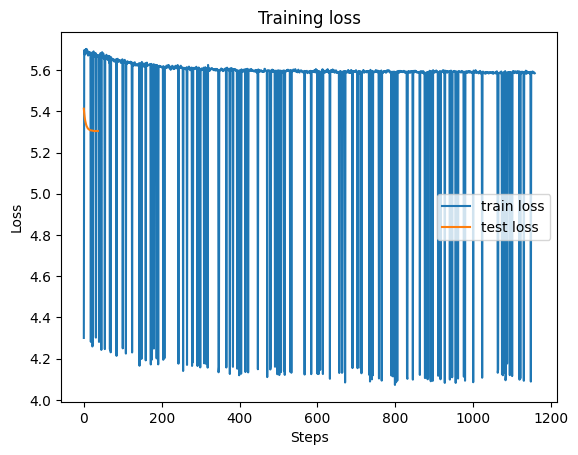

In [103]:
plt.plot(metrics['train_loss'], label='train loss')
plt.plot(metrics['test_loss'], label='test loss')

plt.title('Training loss')
plt.ylabel('Loss')
plt.xlabel('Steps')
plt.legend()

In [104]:
num2sent = {0 : 'negative', 1 : 'neutral', 2 : 'positive', 3 : 'both'}
asp2num = {'Food': 0, 'Interior': 1, 'Price': 2, 'Service': 3, 'Whole': 4}

def asp_sent(row):
  pred = model(row['input'] + ' [CLS] '+ row['context'], torch.tensor([asp2num[row['aspect']]]))
  return num2sent[torch.argmax(pred).item()]

In [105]:
df_pred = train_set.contexts.copy()

In [106]:
df_pred['sent_pred'] = df_pred.apply(asp_sent, axis = 1)

**Test accuracy:**

In [107]:
len(df_pred.loc[df_pred['sentiment'] == df_pred['sent_pred']])/len(df_pred)

0.2815

- Вариант с моделью для специально нашей задачи: качество не лучше (лосс не падает)
- Более сложная архитектура дообучения, описанная в классе модели в self.main, тоже не сработала

###(2) С помощью предобученной модели для оценки тональности классифицируем предложения, в котороых содержатся выделнные сущности

Как в бейзлайне 3, но без сборки по категории. Плохо сработало, качество около 50%, так как в одном предложении часто несколько сущностей (а при таком подходе им ещё приписывается одна тональность)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_checkpoint = 'cointegrated/rubert-tiny-sentiment-balanced'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
if torch.cuda.is_available():
    model.cuda()

def get_sentiment(text, return_type='label'):
    """ Calculate sentiment of a text. `return_type` can be 'label', 'score' or 'proba' """
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
        proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()[0]
    if return_type == 'label':
        return model.config.id2label[proba.argmax()]
    elif return_type == 'score':
        return proba.dot([-1, 0, 1])
    return proba

In [ ]:
def score(proba):
  neg, neut, pos = proba
  if abs(neg - pos) < 0.05:
    return 'both'
  elif abs(neg - neut) < 0.05 and abs(pos - neut) < 0.05:
    return 'neutral'
  else:
    return model.config.id2label[proba.argmax()]

In [ ]:
df_pred['sent_pred_2'] = df_pred['context'].apply(lambda x: score(get_sentiment(x, 'proba')))

**Accuracy:**

In [ ]:
len(df_pred.loc[df_pred['sentiment'] == df_pred['sent_pred_2']])/len(df_pred)